# Fake News Detction Model
* Author: Ji Hoon Chung

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import string
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve, auc, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from wordcloud import WordCloud,STOPWORDS
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import inaugural
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import WhitespaceTokenizer as w_tokenizer
warnings.filterwarnings('ignore')

## 1. EDA

### 1.1 Explore & Clean Up Data

In [57]:
# Import Dataset
df = pd.read_csv("news 2.csv")

In [58]:
# Dataset Overview
df.sample(10)

,Unnamed: 0,title,text,label
3327,5421,Why Sprott Believes Gold Bullion Is A Mandator...,Why Sprott Believes Gold Bullion Is A Mandator...,FAKE
2196,6406,"Political Party of Anarchists, Libertarians, H...",By Claire Bernish at thefreethoughtproject.com...,FAKE
2676,2103,"Climate change happening 'right now,' Obama sa...",WASHINGTON — President Obama sought to spotlig...,REAL
5851,8165,"All Governments Lie, The Movie",October Boomerang ‹ › David Swanson is an auth...,FAKE
1566,8345,Astronomers Think They Have Just Discovered Me...,The Daily Sheeple \nby Jake Anderson \nAnomalo...,FAKE
454,1146,"Cruz camp responds to Rubio Photoshop flap, br...",Sen. Ted Cruz’s national spokesman Rick Tyler ...,REAL
1612,9165,Will Hillary Clinton Get America Back on Track?,Will Hillary Clinton Get America Back on Track...,FAKE
2219,3257,Funding shortfall for Social Security disabili...,Republicans say Social Security’s support for ...,REAL
2296,7921,How WiFi & Other EMFs Cause Biological Harm,How WiFi & Other EMFs Cause Biological Harm Pr...,FAKE
3693,6330,Re: OUCH! Hillary Clinton’s self-unaware lectu...,"— Tim Carney (@TPCarney) October 27, 2016 \nUh...",FAKE


It seems like most of the news are political within political category.

In [59]:
df.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

Null value does not exist within the dataset.

In [60]:
# Combine Title into text and drop title from the dataframe.
df['text'] = df['title'] + df['text']
df.drop('title', inplace=True, axis=1)

In [61]:
# Text and Title are combined.
df.head()

,Unnamed: 0,text,label
0,8476,"You Can Smell Hillary’s FearDaniel Greenfield,...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathyU.S...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,FAKE
4,875,The Battle of New York: Why This Primary Matte...,REAL


In [62]:
# Drop unnecessary columns.
df = df.drop(['Unnamed: 0'], axis=1)

### 1.1.1 Lemmatize & Stem Dataset

For further evaluations on the datset, I will prepare lemmatized and stemmed dataset of the text.

In [63]:
# Construct Tokenize Dataset
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
df['tokenized_sents'] = df.apply(lambda row: w_tokenizer.tokenize(row['text']), axis=1)

In [64]:
# Lemmatized Function
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text] 

In [65]:
# Construct lemmatized dataset.
df['lemmatized_text'] = df['tokenized_sents'].apply(lemmatize_text)

In [66]:
# Stemmer Function
def stemmer_text(text):
    ps = PorterStemmer()
    return [ps.stem(w) for w in text] 

In [67]:
# Consturct Stemmed dataset.
df['stemmer_text'] = df['tokenized_sents'].apply(stemmer_text)

In [68]:
# Final X Dataset.
df.head()

,text,label,tokenized_sents,lemmatized_text,stemmer_text
0,"You Can Smell Hillary’s FearDaniel Greenfield,...",FAKE,"[You, Can, Smell, Hillary’s, FearDaniel, Green...","[You, Can, Smell, Hillary’s, FearDaniel, Green...","[you, can, smell, hillary’, feardaniel, greenf..."
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE,"[Watch, The, Exact, Moment, Paul, Ryan, Commit...","[Watch, The, Exact, Moment, Paul, Ryan, Commit...","[watch, the, exact, moment, paul, ryan, commit..."
2,Kerry to go to Paris in gesture of sympathyU.S...,REAL,"[Kerry, to, go, to, Paris, in, gesture, of, sy...","[Kerry, to, go, to, Paris, in, gesture, of, sy...","[kerri, to, go, to, pari, in, gestur, of, symp..."
3,Bernie supporters on Twitter erupt in anger ag...,FAKE,"[Bernie, supporters, on, Twitter, erupt, in, a...","[Bernie, supporter, on, Twitter, erupt, in, an...","[berni, support, on, twitter, erupt, in, anger..."
4,The Battle of New York: Why This Primary Matte...,REAL,"[The, Battle, of, New, York:, Why, This, Prima...","[The, Battle, of, New, York:, Why, This, Prima...","[the, battl, of, new, york:, whi, thi, primari..."


In [136]:
def list_to_string(text):
    return ' '.join(str(e) for e in text)

In [141]:
# Convert List to String
df['lemmatized_text'] = df['lemmatized_text'].apply(list_to_string)
df['stemmer_text'] = df['stemmer_text'].apply(list_to_string)

In [149]:
df.head()

,text,label,tokenized_sents,lemmatized_text,stemmer_text,words_used
0,"You Can Smell Hillary’s FearDaniel Greenfield,...",FAKE,"[You, Can, Smell, Hillary’s, FearDaniel, Green...","You Can Smell Hillary’s FearDaniel Greenfield,...","you can smell hillary’ feardaniel greenfield, ...",1300.0
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE,"[Watch, The, Exact, Moment, Paul, Ryan, Commit...",Watch The Exact Moment Paul Ryan Committed Pol...,watch the exact moment paul ryan commit polit ...,459.0
2,Kerry to go to Paris in gesture of sympathyU.S...,REAL,"[Kerry, to, go, to, Paris, in, gesture, of, sy...",Kerry to go to Paris in gesture of sympathyU.S...,kerri to go to pari in gestur of sympathyu.s. ...,439.0
3,Bernie supporters on Twitter erupt in anger ag...,FAKE,"[Bernie, supporters, on, Twitter, erupt, in, a...",Bernie supporter on Twitter erupt in anger aga...,berni support on twitter erupt in anger agains...,418.0
4,The Battle of New York: Why This Primary Matte...,REAL,"[The, Battle, of, New, York:, Why, This, Prima...",The Battle of New York: Why This Primary Matte...,the battl of new york: whi thi primari matters...,325.0


### 1.2 Explore Data

In [72]:
df["words_used"] = np.nan

In [73]:
## See how may words are used per text
for i in range(len(df.text)-1):
    df['words_used'].iloc[i] = len(df['text'].iloc[i].split())

In [74]:
df_words = df.groupby('label').agg({'words_used':['mean', 'median', 'std', 'min', 'max']})

In [75]:
res = len(df['text'].iloc[1].split())

In [76]:
df_words

words_used                                  
             mean median         std   min      max
label                                              
FAKE   689.353034  432.0  958.966693   3.0  20903.0
REAL   882.134385  780.5  723.131382  11.0   7625.0

FAKE news articles contains less mean & median number of words whereas their standard deviation is a lot larger indicating they have more versatility in lengh of an article.

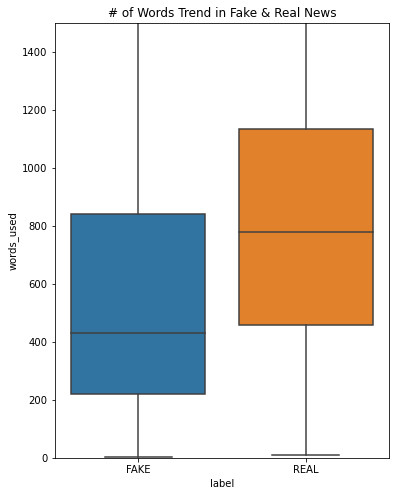

In [77]:
fig, ax = plt.subplots(figsize=(6,8))
ax = sns.boxplot(x='label', y='words_used', data=df)
ax.set_ylim(0,1500)
ax.set_title('# of Words Trend in Fake & Real News')
plt.show();

Overally, FAKE news has lower spectrum of length compared to REAL news.

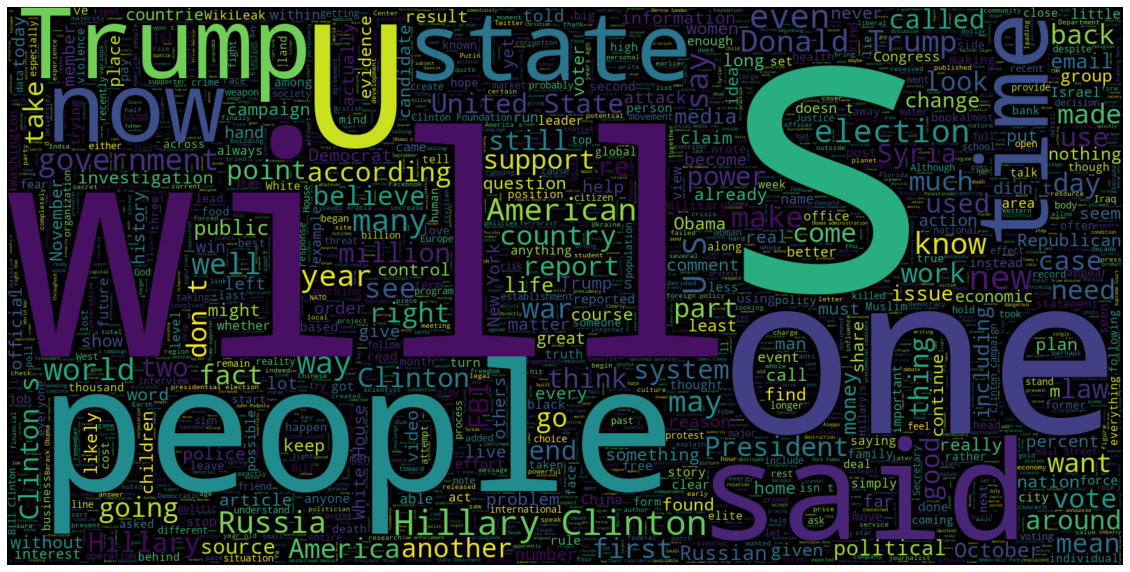

In [78]:
# Fake News Word Cloud
plt.figure(figsize = (20,20)) # Text from the real news articles
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(df[df.label == 'FAKE'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show;

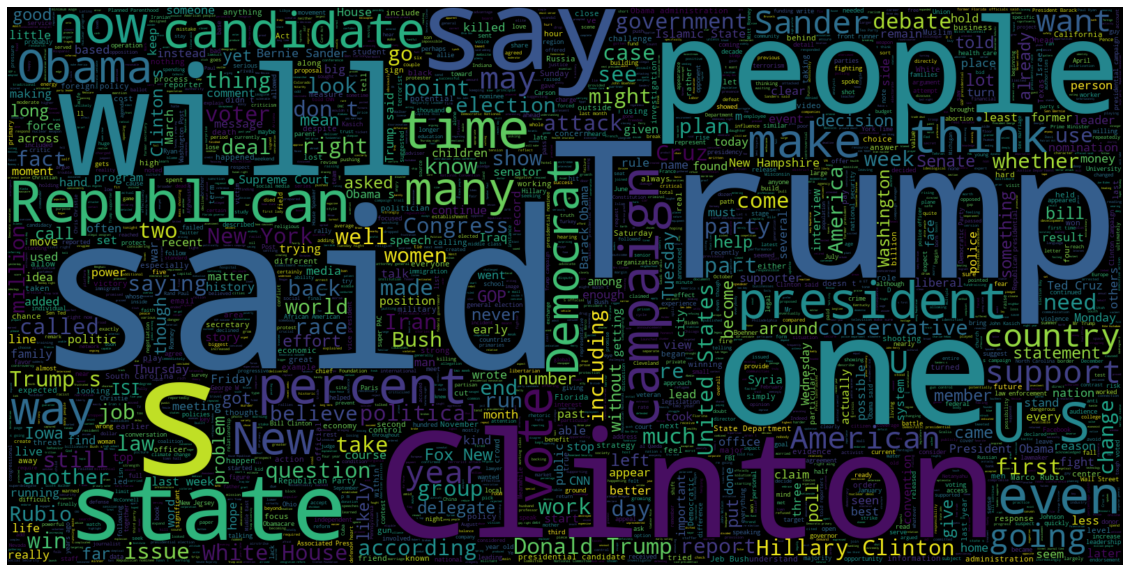

In [79]:
# Real News Word Cloud
plt.figure(figsize = (20,20)) # Text from the real news articles
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(df[df.label == 'REAL'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show;

Looking at word Cloud, it's hard to tell the distinction between two types of articles. However, it is evident that both articles are mainly about the US politics.

***

## 2. General Modeling

## 2.1 Splitting Dataset for Modeling.

In [95]:
# Original Text X
X_text = df['text']

# Stemmed Text X
X_stem = df['stemmer_text']

#Lemmatized Text X
X_lem = df['lemmatized_text']

#Target Variable
y = df['label']

In [257]:
y = pd.DataFrame(np.where(y=='FAKE', 1, 0))

In [97]:
#DataFlair - Split the dataset (For Original Text)
x_text_train, x_text_test, y_text_train, y_text_test=train_test_split(X_text, y, test_size=0.2, random_state=7)

In [146]:
#DataFlair - Split the dataset (For Stemmed Text)
x_stem_train, x_stem_test, y_stem_train, y_stem_test=train_test_split(X_stem, y, test_size=0.2, random_state=7)

In [147]:
#DataFlair - Split the dataset (For Lemmatized Text)
x_lem_train, x_lem_test, y_lem_train, y_lem_test=train_test_split(X_lem, y, test_size=0.2, random_state=7)

## 2.2 Decision Tree Model (Without Adjusting Class Balance)

In [209]:
# Build a pipeline with TfIDFVectorizer and Decision Tree Classifer
tree_tf_pipeline = Pipeline([('vect',TfidfVectorizer()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search
gs1 = GridSearchCV(estimator=tree_tf_pipeline, 
                          param_grid=grid, 
                          scoring='f1_micro', 
                          cv=5)

In [210]:
# Build a pipeline with CountVectorizer and Decision Tree Classifer
tree_ct_pipeline = Pipeline([('vect',CountVectorizer()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search
gs2 = GridSearchCV(estimator=tree_ct_pipeline, 
                          param_grid=grid, 
                          scoring='f1_micro', 
                          cv=5)

### 2.2.1 TFIDF Vectorizer Cross Validation Results

In [211]:
# Using Original Text Dataset
gs1.fit(x_text_train, y_text_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

Best F1_Score: 0.814


In [150]:
# Using Lemmatized Text Dataset
gs1.fit(x_lem_train, y_text_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

Best F1_Score: 0.814


In [228]:
# Using Stemmed Text Dataset
gs1.fit(x_stem_train, y_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

Best F1_Score: 0.815


For TfIDF Vectorizer, Best F1_Score came with the Stemmed Text Dataset

### 2.2.2 CountVectorizer Cross Validation Results

In [151]:
# Using Original Text Dataset
gs2.fit(x_text_train, y_text_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs2.best_score_)

Best F1_Score: 0.815


In [154]:
# Using Stemmed Text Dataset
gs2.fit(x_stem_train, y_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

Best F1_Score: 0.815


In [155]:
# Using Lemmatized Text Dataset
gs2.fit(x_lem_train, y_text_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

Best F1_Score: 0.815


For CountVectorizer, All the Datasets have to same F1_Score

### 2.2.3 Decision Tree Model Evaluation

<B>TFIDF Vectorizer with Stemmed Datasets showed best F1_Score in validation Score.

In [229]:
# Predicting the model for tf-idf features
tree_tf_stem_pred = gs1.predict(x_stem_test)

In [237]:
# Check the accuracy score for tfidf features
Tree_tfidf_score=accuracy_score(y_stem_test, tree_tf_stem_pred)
print("Decision Tree TF-IDF accuracy score:", Tree_tfidf_score)

Decision Tree TF-IDF accuracy score: 0.8089976322020521


In [251]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs1_x_test_tfidf = gs1.best_estimator_.named_steps['vect'].transform(x_stem_test)

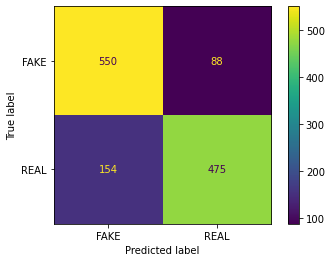

In [249]:
Tree_cm = plot_confusion_matrix(gs1.best_estimator_.named_steps['tree'], gs1_x_tfidf , y_stem_test);

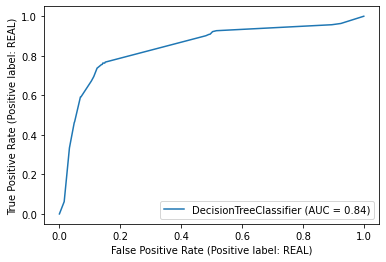

In [250]:
Tree_roc = plot_roc_curve(gs1.best_estimator_.named_steps['tree'] ,gs1_x_tfidf, y_test)

In [225]:
Tree_tfidf_report = classification_report(y_test, Tree_tfidf_pred, target_names = ['FAKE','REAL'])
print(Tree_tfidf_report)

              precision    recall  f1-score   support

        FAKE       0.82      0.84      0.83       638
        REAL       0.83      0.81      0.82       629

    accuracy                           0.83      1267
   macro avg       0.83      0.83      0.83      1267
weighted avg       0.83      0.83      0.83      1267



Accuray of model with the raw dataset seems pretty satisfying. However, class imbalance clearly exists between REAL vs FAKE news in Real World. Since my mission is to bring a model that can be fully utilized in real world, I will bring in class imbalance of target variable in the next section. 

***

## 3. Modeling After Setting Up Class Imbalance.

By the numbers: In 2020, nearly one-fifth <b>(17%)</b> of engagement among the top 100 news sources on social media came from sources that NewsGuard deems generally unreliable, compared to about 8% in 2019.<br>
<br>
Source = https://www.axios.com/unreliable-news-sources-social-media-engagement-297bf046-c1b0-4e69-9875-05443b1dca73.html?utm_campaign=organic&utm_medium=socialshare&utm_source=twitter

<B>Entire Dataset will be re-sampled into 0.17:1.0 FAKE to REAL news ratio so that it actually resembles FAKE news ratio being spread in the real world.

## 3.1 Resampling Dataset (0.17 : 1.0) FAKE to REAL

In [252]:
from imblearn.datasets import make_imbalance

In [254]:
# Original Text X
X_text = pd.DataFrame(X_text)

# Stemmed Text X
X_stem = pd.DataFrame(X_stem)

#Lemmatized Text X
X_lem = pd.DataFrame(X_lem)

In [258]:
# Original Text, Create imbalanced Dataset (0.17:1 Fake vs. Real News Ratio)
x_im_text, y_im_text = make_imbalance(X_text,y,sampling_strategy={1: 539, 0: 3171})

# Stemmed Text, Create imbalanced Dataset (0.17:1 Fake vs. Real News Ratio)
x_im_stem, y_im_stem = make_imbalance(X_stem,y,sampling_strategy={1: 539, 0: 3171})

# Lemmatized Text, Create imbalanced Dataset (0.17:1 Fake vs. Real News Ratio)
x_im_lem, y_im_lem = make_imbalance(X_lem,y,sampling_strategy={1: 539, 0: 3171})

In [270]:
x_im_text = x_im_text['text']
x_im_stem = x_im_stem['stemmer_text']
x_im_lem = x_im_lem['lemmatized_text']

In [272]:
#DataFlair - Split the dataset - Original text
x_im_train, x_im_test, y_im_train, y_im_test = train_test_split(x_im_text, y_im_text, test_size=0.2, random_state=7)

#DataFlair - Split the dataset - Stemmed text
x_im_stem_train, x_im_stem_test, y_im_stem_train, y_im_stem_test = train_test_split(x_im_stem, y_im_stem, test_size=0.2, random_state=7)

#DataFlair - Split the dataset - Lemmaitzed text
x_im_lem_train, x_im_lem_test, y_im_lem_train, y_im_lem_test = train_test_split(x_im_lem, y_im_lem, test_size=0.2, random_state=7)

Dataset & Splitting is Ready!

## 3.2 Dummy Model after resampling Dataset

Dummy Model needs to be constructed to evaluate performance going forward as Target Variable class is highly imbalanced.<br>
Model for only one of the datasets would be necessary as it is Dummy Classifier.

In [273]:
# Build a pipeline with TFIDF and DummyClassifer
dummy_pipeline = Pipeline([('vect',TfidfVectorizer()),
                 ('dummy',DummyClassifier())])

# Define the grid
grid_3 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'dummy__strategy': ['most_frequent']}]

# Define a grid search
gs_3 = GridSearchCV(estimator=dummy_pipeline, 
                          param_grid=grid_3, 
                          scoring='f1_micro', 
                          cv=5)

In [274]:
# Fit the training data
gs_3.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_3.best_score_)

Best F1_Score: 0.854


In [276]:
# Predicting the model for tf-idf features
dummy_pred = gs_3.predict(x_im_test)

In [277]:
# Check the accuracy score for tfidf features
dummy_score=accuracy_score(y_im_test, dummy_pred)
print("Decision Tree TF-IDF accuracy score:", dummy_score)

Decision Tree TF-IDF accuracy score: 0.8571428571428571


In [278]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs_3_x_test_tfidf = gs_3.best_estimator_.named_steps['vect'].transform(x_im_test)

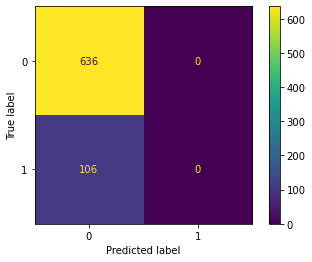

In [285]:
dummy_cm = plot_confusion_matrix(gs_3.best_estimator_.named_steps['dummy'], gs_3_x_test_tfidf, y_im_test);

In [310]:
dummy_report = classification_report(y_im_test, dummy_pred, target_names = ['0', '1'])
print(dummy_report)

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       636
           1       0.00      0.00      0.00       106

    accuracy                           0.86       742
   macro avg       0.43      0.50      0.46       742
weighted avg       0.73      0.86      0.79       742



<b>Since Dummy Score has Accuracy-Score of 0.857, our model should draw Accuracy Score at least better than 0.857.

## 3.3 Decision Tree Model after Data Split

In [286]:
# Build a pipeline with TFIDF, SMOTE and Decision Tree Classifer, SMOTE was added to rebalance Training Data.
tree_pipeline_2 = Pipeline([('vect',TfidfVectorizer()),
                            ('smote', SMOTE()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid_4 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search
gs_4 = GridSearchCV(estimator=tree_pipeline_2, 
                          param_grid=grid_4, 
                          scoring='f1_micro', 
                          cv=5)

In [294]:
# Build a pipeline with TFIDF, SMOTE and CountVectorizer, SMOTE was added to rebalance Training Data.
tree_pipeline_3 = Pipeline([('vect',CountVectorizer()),
                            ('smote', SMOTE()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid_5 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search
gs_5 = GridSearchCV(estimator=tree_pipeline_3, 
                          param_grid=grid_5, 
                          scoring='f1_micro', 
                          cv=5)

### 3.3.1 TFIDF Vectorizer Cross Validation Results

In [291]:
# Using Lemmatized Text Dataset
gs_4.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_4.best_score_)

Best F1_Score: 0.860


In [292]:
# Using Stemmed Text Dataset
gs_4.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_4.best_score_)

Best F1_Score: 0.856


In [298]:
# Using Original Text Dataset
gs_4.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_4.best_score_)

Best F1_Score: 0.868


### 3.3.2 CountVectorizer Cross Validation Results

In [295]:
# Using Original Text Dataset
gs_5.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_5.best_score_)

Best F1_Score: 0.827


In [296]:
# Using Lemmatized Text Dataset
gs_5.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_5.best_score_)

Best F1_Score: 0.849


In [297]:
# Using Stemmed Text Dataset
gs_5.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_5.best_score_)

Best F1_Score: 0.826


### 3.3.3 Decision Tree Model Evaluation

In [299]:
# Predicting the model for tf-idf features
tree_tf_imb_pred = gs_4.predict(x_im_test)

In [301]:
# Check the accuracy score for tfidf features
Tree_tfimb_score=accuracy_score(y_im_test, tree_tf_imb_pred)
print("Decision Tree TF-IDF accuracy score:", Tree_tfimb_score)

Decision Tree TF-IDF accuracy score: 0.8692722371967655


In [302]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs4_x_test_tfimb = gs_4.best_estimator_.named_steps['vect'].transform(x_im_test)

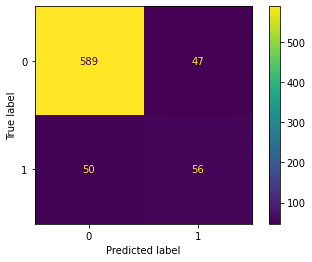

In [305]:
Tree_imb_cm = plot_confusion_matrix(gs_4.best_estimator_.named_steps['tree'], gs4_x_test_tfimb , y_im_test);

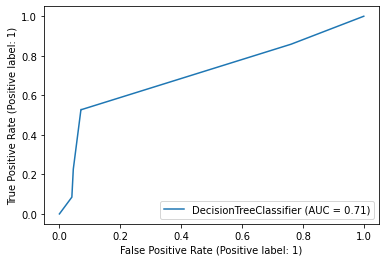

In [306]:
Tree_imb_roc = plot_roc_curve(gs_4.best_estimator_.named_steps['tree'] ,gs4_x_test_tfimb, y_im_test)

In [308]:
Tree_tfimb_report = classification_report(y_im_test, tree_tf_imb_pred, target_names = ['0','1'])
print(Tree_tfimb_report)

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       636
           1       0.54      0.53      0.54       106

    accuracy                           0.87       742
   macro avg       0.73      0.73      0.73       742
weighted avg       0.87      0.87      0.87       742



Accuracy Score is better than DummyClassifier at 0.869 which is <b>0.012</b> higher than DummyClassifer.<br>
However, we could do better than this.

## 3.4 RandomForest Model after Data Split


In [98]:
# Build a pipeline with StandardScaler and RandomForestClassifier
rdf_pipeline = Pipeline([('vect',TfidfVectorizer()),
                 ('rdf',RandomForestClassifier())])

# Define the grid
grid_4 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'rdf__n_estimators': [10, 20, 30, 40]}]

# Define a grid search
gs_4 = GridSearchCV(estimator=rdf_pipeline, 
                          param_grid=grid_4, 
                          scoring='f1_micro', 
                          cv=5)

In [99]:
# Fit the training data
gs_4.fit(x_train, y_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_4.best_score_)

Best F1_Score: 0.877


In [61]:
# Predicting the model for tf-idf features
rf_tfidf_im_pred = rf_clf.predict(tfidf_test)

In [62]:
# Check the accuracy score for tfidf features
rf_tfidf_im_score=accuracy_score(y_test, rf_tfidf_im_pred)
print("Random Forest TF-IDF accuracy score:", rf_tfidf_im_score)

Random Forest TF-IDF accuracy score: 0.8935309973045822


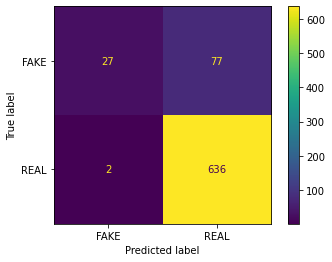

In [63]:
plot_confusion_matrix(rf_tfidf, tfidf_test, y_test);

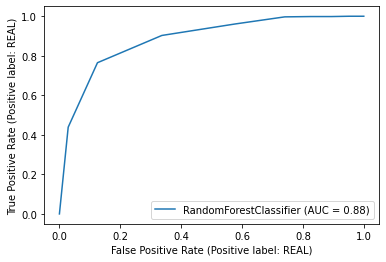

In [65]:
plot_roc_curve(rf_tfidf ,tfidf_test, y_test);

In [68]:
rf_tfidf_report = classification_report(y_test, rf_tfidf_im_pred, target_names = ['FAKE','REAL'])
print(rf_tfidf_report)

              precision    recall  f1-score   support

        FAKE       0.93      0.26      0.41       104
        REAL       0.89      1.00      0.94       638

    accuracy                           0.89       742
   macro avg       0.91      0.63      0.67       742
weighted avg       0.90      0.89      0.87       742



Good Precision, but frustrating Recall score.

### 2.2.4 Multinomial Model after Data Split